In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scripts.setup_data as setup_data
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from utilities import parse_json, hash_id, run_api, add_noise
from constants import *
from model_info import model_configs
from openai import OpenAI
import json
import anthropic
from anthropic.types.message_create_params import MessageCreateParamsNonStreaming
from anthropic.types.messages.batch_create_params import Request

/Users/ElliotKim/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loads initial raw data and determines the ideal number of clusters to split dataset to generate clusters of jobs of and resumes with highest cosine similarity.

In [ ]:
resume_df, job_df = setup_data.load_raw_data()
resume_embeddings, job_embeddings = setup_data.generate_embeddings(resume_df, job_df)
similarities = setup_data.calculate_similarity(resume_embeddings, job_embeddings)

### Code to generate Figure 6a (Appendix A)

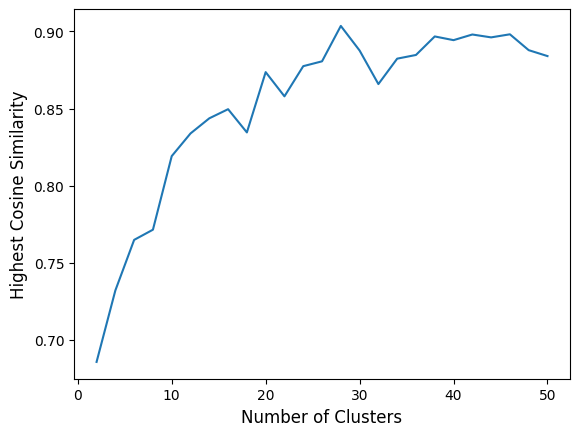

In [18]:
x = np.arange(2,52,2)
y = similarities
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Highest Cosine Similarity", fontsize=12)
plt.plot(x,y)
plt.savefig(f'final_figures/4.3_cosine_similarity_vs_num_clusters.pdf', dpi=3000, bbox_inches="tight")
plt.show()

In [ ]:
num_clusters = 28
kmeans_resumes = KMeans(n_clusters=num_clusters, random_state=0).fit(resume_embeddings)
kmeans_jobs = KMeans(n_clusters=num_clusters, random_state=0).fit(job_embeddings)

resume_df['resume_cluster'] = kmeans_resumes.labels_
job_df['job_cluster'] = kmeans_jobs.labels_

resume_centroids = kmeans_resumes.cluster_centers_
job_centroids = kmeans_jobs.cluster_centers_

# Compute cosine similarity between centroids
similarity_matrix = cosine_similarity(resume_centroids, job_centroids)

similarity_flat = similarity_matrix.flatten()
top_3_indices = np.argsort(similarity_flat)[-20:][::-1]
top_3_clusters = np.unravel_index(top_3_indices, similarity_matrix.shape)

print("\nTop 3 most similar clusters:")
for idx in range(5):
    print(f"Pair {idx+1}: Resume Cluster {top_3_clusters[0][idx]} and Job Cluster {top_3_clusters[1][idx]} with similarity {similarity_matrix[top_3_clusters[0][idx], top_3_clusters[1][idx]]}")


Top 3 most similar clusters:
Pair 1: Resume Cluster 26 and Job Cluster 23 with similarity 0.9034857749938965
Pair 2: Resume Cluster 10 and Job Cluster 1 with similarity 0.8810179829597473
Pair 3: Resume Cluster 24 and Job Cluster 22 with similarity 0.8472327589988708
Pair 4: Resume Cluster 23 and Job Cluster 13 with similarity 0.8427616357803345
Pair 5: Resume Cluster 27 and Job Cluster 23 with similarity 0.8350468277931213


We chose Pair 1 (web development related), Pair 2 (general IT related), and Pair 4(consulting/finance related) to use for our experiments.

In [ ]:
#export updated dataframes
jobs = job_df[['Content', 'job_cluster']]
job_clusters = [1,23,13]
jobs_df = pd.DataFrame()
for cluster in job_clusters:
    sampled = jobs[jobs['job_cluster']==cluster].sample(10, random_state=123)
    jobs_df = pd.concat([jobs_df, sampled])
    
jobs_df = jobs_df.reset_index(drop = True)

resume_clusters = [10,26,23]
resumes_df = pd.DataFrame()
for cluster in resume_clusters:
    sampled = resume_df[resume_df['resume_cluster']==cluster].sample(20, random_state=123)
    resumes_df = pd.concat([resumes_df, sampled])
resumes_df = resumes_df.reset_index(drop = True)

df = pd.merge(jobs_df, resumes_df, how = "cross").rename(columns={"Content":"Job"}).reset_index()
df['index'] = df['index'].apply(hash_id)

jobs = df['Job'].unique()
resumes = df['Resume'].unique()

resume_id_map = {resume: hash_id(resume) for resume in resumes}
job_id_map = {job: hash_id(job) for job in jobs}

df['Resume_index'] = df['Resume'].map(resume_id_map)
df['Job_index'] = df['Job'].map(job_id_map)
df['Resume'] = "<div class='resume'> " + df['Resume'] + "</div>"
df['Job'] = "<div class='job'>" + df['Job'] + "</div>"


### Generate and Store LLM data

We used Amazon Bedrock On-Demand for models that were supported by AWS. These were all models from Meta, Mistral AI, and Amazon. The code below stores the scores generated by each model-prompt pair. 

To run the code successfully, users must first log in to a working AWS account with access to Amazon Bedrock and ensure that their credentials are properly configured (e.g., using aws sso login or environment variables).

Since AWS credential sessions (e.g., through IAM Identity Center) have a maximum duration of 12 hours, users running large-scale jobs should split the workload into smaller chunks or implement session refresh logic to avoid interruptions.

In [ ]:
prompts = [firm_rate_comb2, firm_rate_comb_short_1, app_rate_comb_short]
name_dic = {firm_rate_comb2: "firm_rate_comb2",
            app_rate_comb_short: "app_rate_comb_short",
            firm_rate_comb_short_1: "firm_rate_comb_short_1"}

amazon_models = [
    'us.amazon.nova-lite-v1:0',
    'us.amazon.nova-micro-v1:0',
    'us.amazon.nova-pro-v1:0'
]

mistral_models = [
    'mistral.mistral-7b-instruct-v0:2',
    'mistral.mistral-large-2402-v1:0',
    'mistral.mistral-large-2407-v1:0',
    'mistral.mixtral-8x7b-instruct-v0:1'
]

meta_models = [
    'meta.llama3-70b-instruct-v1:0',
    'meta.llama3-1-8b-instruct-v1:0',
    'meta.llama3-1-70b-instruct-v1:0',
    'meta.llama3-1-405b-instruct-v1:0',
    'us.meta.llama3-2-11b-instruct-v1:0',
    'us.meta.llama3-2-90b-instruct-v1:0',
    'us.meta.llama3-3-70b-instruct-v1:0'
]
models = amazon_models + mistral_models + meta_models 
for row, col in df[1722:].iterrows():
    resume = col['Resume']
    job = col['Job']
    for modelId in models:
        model = model_configs[modelId]
        for p in prompts:
            prompt = p + f"""
            
            Resume: {resume}

            Job Description: {job}

            Json File:

            Assistant:
            """
            output=''
            cost = model['cost_mapping'][0] * len(prompt)
            try:
                raw_text, output = run_api(modelId, model['config'], prompt)
#                 print(row, model, raw_text, output)
                df.at[row, f"{model['short_name']}_{name_dic[p]}_raw"] = raw_text
                if output is not None:
                    score = output['Score']
                    df.at[row, f"{model['short_name']}_{name_dic[p]}"] = score
            except Exception as e:
                print(output, e)

#### For Claude Batch

In [ ]:
CLAUDE_API_KEY =""
claude_client = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

In [ ]:
claude_models = ['claude-3-5-sonnet-20241022','claude-3-5-haiku-20241022','claude-3-haiku-20240307']
for model in claude_models:
  for p in prompts:
    requests = []
    for row, col in df.iterrows():
        user_prompt= f"""
        Resume: {col['Resume']}

        Job Description: {col['Job']}

        Json File:
        """
        request = Request(
            custom_id=col['index'],
            params=MessageCreateParamsNonStreaming(
                model=model,
                max_tokens=1024,
                messages=[{
                    "role": "user",
                    "content": p + "\n" + user_prompt,
                }],
                temperature = 0.0,
                top_p = 0.9
            )
        )
        requests.append(request)
    message_batch = claude_client.messages.batches.create(
        requests=requests
    )
  print(message_batch)

The code above generates a batch for each model-prompt pair. After a successful batch, user needs to download each output jsonl file and store it in the /data directory. The code below shows an example of one of the model-prompt pairs. User will need to modify the model variable, prompt column name, and file path accordingly. Depending on the user's API tier, one may need to partition the original dataset.

In [ ]:
# the path will depend on where you save the jsonl file. this is just an example
file = "../data/t9/claude/claude-3-5-sonnet-20241022_firm_comb2.jsonl"
with open(file,'r') as f:
    model = "Claude_3.5_Sonnet(20241022)"
    for i, line in enumerate(f):
        data = json.loads(line)
        row = df[df['index']==data['custom_id']].index[0]
        if data['result']['type']=="succeeded":
#             print(data['result'])
            raw_text = data['result']['message']['content'][0]['text']
            df.at[row, f"{model}_firm_rate_comb2_raw"] = raw_text
            output = parse_json(raw_text)[0]
            if output and 'Score' in output:
                df.at[row, f"{model}_firm_rate_comb2"] = output['Score']

#### For OpenAI Batch

In [ ]:
OPENAI_API_KEY = ""
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
## Create input jsonl file for Batch
## gpt-4o-mini and gpt 3.5 turbo supports "system", and o1-mini doesn't
for i, p in enumerate(prompts):
    with open(f"../data/t9/o1-mini_{name_dic[p]}.jsonl", 'w') as f:
        for row, col in df.iterrows():
            user_prompt= f"""
            Resume: {col['Resume']}

            Job Description: {col['Job']}

            Json File:
            """
            item = {
                "custom_id": f"{col['index']}_{name_dic[p]}", 
                "method": "POST", 
                "url": "/v1/chat/completions", 
                "body": {
                    "model": "o1-mini", 
                    "messages": [
                        {"role": "user", "content": p + "\n" + user_prompt}
                    ],
                },
                # "body": {
                #     "model": "gpt-3.5-turbo", 
                #     "messages": [
                #         {"role": "system", "content": p}, 
                #         {"role": "user", "content": user_prompt}
                #     ],
                #     "temperature": 0.0,
                #     "top_p":0.9
                # }
            }
            f.write(json.dumps(item) + "\n")

In [ ]:
# upload file to API
client.files.create(
  file=open("../data/t9/openai/batch_input/gpt-3.5-turbo_firm_rate_comb2.jsonl", "rb"),
  purpose="batch"
)

# create batch gpt-4o-mini_firm_rate_comb2_3
client.batches.create(
  input_file_id="file-AKwxBA4fmAMrmztGhLcwWj",
  endpoint="/v1/chat/completions",
  completion_window="24h"
)

Similarly to Anthropic Claude's API, the code above generates a batch for each model-prompt pair. After a successful batch, user needs to download each output jsonl file and store it in the /data directory. The code below shows an example of one of the model-prompt pairs. User will need to modify the model variable, prompt column name, and file path accordingly. Depending on the user's API tier, one may need to partition the original dataset.

In [ ]:
results = []
result_file_name = "../data/t9/openai/batch_output/gpt-3.5-turbo_firm_rate_comb2_batch_1_result.jsonl"
with open(result_file_name, 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        results.append(json_object)
result_file_name = "../data/t9/openai/batch_output/gpt-3.5-turbo_firm_rate_comb2_batch_2_result.jsonl"
with open(result_file_name, 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        results.append(json_object)
result_file_name = "../data/t9/openai/batch_output/gpt-3.5-turbo_firm_rate_comb2_batch_3_result.jsonl"
with open(result_file_name, 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        results.append(json_object)

for row, res in enumerate(results):
    raw_content = res['response']['body']['choices'][0]['message']['content']
    score = parse_json(raw_content)[0]['Score']
    df.at[row, "Gpt-3.5-turbo_firm_rate_comb2_raw"] = raw_content
    df.at[row, "Gpt-3.5-turbo_firm_rate_comb2"] = score

### Load Hand label data

Labelling can be done in various ways. The most basic way would be manually grading the fit of a resume on a job description on a spreadsheet like Excel or Google Sheets by creating a separate column called "Hand_firm_rate_comb".

In [ ]:
## Sampling a subset of jobs and resumes for hand labelling.
job_sampled = []
for jc in job_clusters:
    jobs = df[df['job_cluster'] == jc]['Job'].unique()
    job_sampled.extend(pd.Series(jobs).sample(5, random_state=123))
job_sampled = list(set(job_sampled))

# Sample 10 resumes per cluster
resume_sampled = []
for rc in resume_clusters:
    resumes = df[df['resume_cluster'] == rc]['Resume'].unique()
    resume_sampled.extend(pd.Series(resumes).sample(10, random_state=123))
resume_sampled = list(set(resume_sampled))

df_sampled = df[
    df['Job'].isin(job_sampled) &
    df['Resume'].isin(resume_sampled)
]


The approach we used was using a text annotation tool called Potato (https://github.com/davidjurgens/potato). Using the interface, we first create a json file to input. 

In [ ]:
file_path = '../data/grade_fit.json'  
with open(file_path, 'w') as json_file:
    for row, col in df_sampled.iterrows():
        entry = {
            'index': str(col['index']),
            'text': [str(col['Job']), str(col['Resume'])]
        }
        json_file.write(json.dumps(entry) + '\n')

After finishing labelling, we read the hand labelled dataset and store the values in our original datset.

In [ ]:
file_path = "../data/hand_labels.json"
data = pd.read_json(file_path, lines=True)
for row, col in data.iterrows():
    score = list(col['label_annotations']['Score'])[0]
    matches = df[
        df['Job'].apply(lambda job: job in col['displayed_text']) &
        df['Resume'].apply(lambda resume: resume in col['displayed_text'])
    ]
    row_num = matches.index[0]
    df.at[row_num, "Hand_firm_rate_comb"] = int(score)
df["Hand_app_rate_comb"]=df['Hand_firm_rate_comb']

#### Load finalized version. Can just run this final cell to load the final dataset used (raw data is hidden)

In [ ]:
df=pd.read_csv('../data/final.csv')

### Code to generate Figure 6b (Appendix A)

In [ ]:
scores_df, _ = setup_data.filter_and_prepare_data(df)
job_clusters = scores_df['job_cluster'].unique()
resume_clusters = scores_df['resume_cluster'].unique()
models=['Mistral-8x7b', 'Mistral-Large', 'Llama3-70b', 'Llama3-1-8b','Llama3-1-70b', 'Llama3-1-405b', 
        'Llama3-2-11b','Llama3-2-90b', 'Llama3-3-70b', 'Claude_3.5_Sonnet(20241022)', 'Claude_3.5_Haiku(20241022)',
       'Gpt-4o-mini','Gpt-o1-mini', 'Nova-Pro','Nova-Micro','Nova-Lite']
prompts = ['firm_rate_comb2', 'app_rate_comb_short']
rows = []

for job_cluster in job_clusters:
    for resume_cluster in resume_clusters:
        adf = scores_df[(scores_df['job_cluster']==job_cluster) & (scores_df['resume_cluster']==resume_cluster)]
        for model in models:
            for prompt in prompts:
                col = f'{model}_{prompt}'
                score = adf[col].mean()
                to_add = {'job_cluster': job_cluster, 'resume_cluster': resume_cluster, 
                          'model': model, 'prompt': prompt, 'score': score}
                rows.append(to_add)
avg_df = pd.concat([pd.DataFrame(rows)], ignore_index=True)

/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_labor_market/scripts/setup_data.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[col] = pd.to_numeric(scores_df[col], errors='coerce')
/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_labor_market/scripts/setup_data.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[cols_to_fill] = scores_df[cols_to_fill].apply(lambda col: col.fillna(col.mean()), axis=0)


/var/folders/r1/pqhz0v150tndhtgcdhn55v1m0000gn/T/ipykernel_55945/851508505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['model'] = filtered_df['model'].str.replace(r'\((.*?)\)', '', regex=True).str.replace('  ', ' ').str.strip()
/var/folders/r1/pqhz0v150tndhtgcdhn55v1m0000gn/T/ipykernel_55945/851508505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['model'] = filtered_df['model'].str.replace(r'\((.*?)\)', '', regex=True).str.replace('  ', ' ').str.strip()
/var/folders/r1/

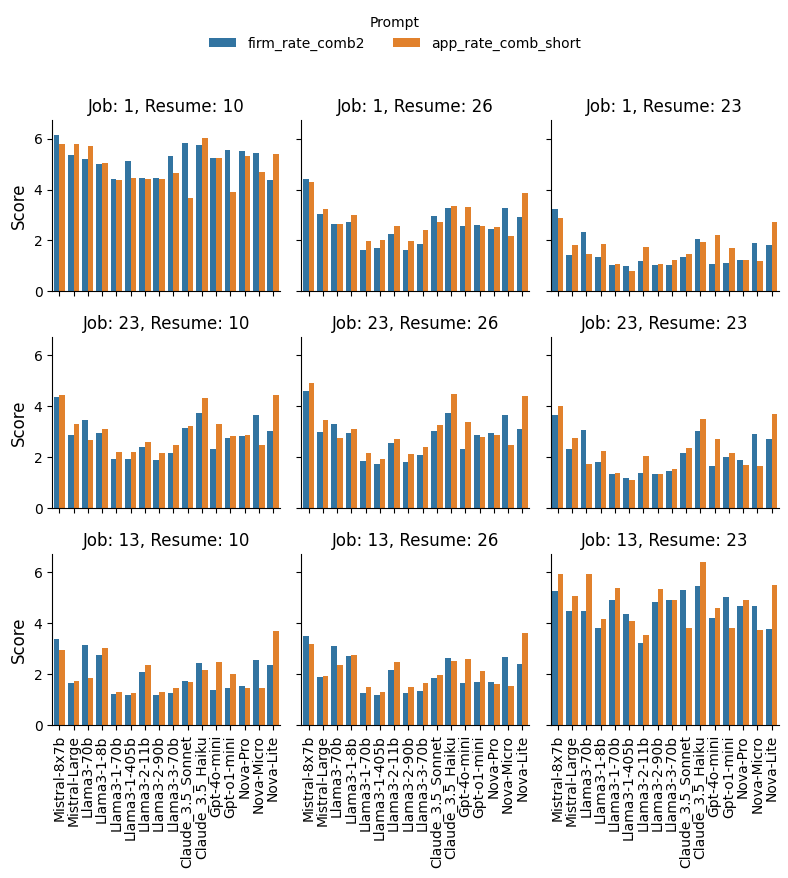

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharey=True, sharex=True)

for i, job_cluster in enumerate(job_clusters):
    for j, resume_cluster in enumerate(resume_clusters):
        filtered_df = avg_df[(avg_df['job_cluster'] == job_cluster) & (avg_df['resume_cluster'] == resume_cluster)]
        filtered_df['model'] = filtered_df['model'].str.replace(r'\((.*?)\)', '', regex=True).str.replace('  ', ' ').str.strip()
        sns.barplot(x='model', y='score', hue='prompt', data=filtered_df, ax=axes[i, j])
        
        # Set title for each subplot
        axes[i, j].set_title(f'Job: {job_cluster}, Resume: {resume_cluster}')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('Score', fontsize=12)
        axes[i, j].tick_params(axis='x', rotation=90, labelsize=10)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title='Prompt', frameon=False)

for ax in axes.flat:
    ax.legend_.remove()
# Adjust layout
plt.tight_layout()
sns.despine()
plt.savefig("../final_figures/4.3_paper_fbedrock_average_scores_across_clusters.pdf", dpi=300, bbox_inches="tight")
plt.show()
